In [1]:
from datetime import datetime
import librosa.display
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import random

from tensorflow.python.keras.layers import Conv1D


# 1. 資料加載與標記

In [2]:
def load_segmented_files(directory, target_sr=32000):
    wav_files = []
    leak_wav_files = []
    print(f"共有 {len(os.listdir(directory))} 個資料夾")
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        print(f"正在處理 {dir} 資料夾，共有 {len(os.listdir(os.path.join(directory, dir)))} 個檔案")
        for file in tqdm(os.listdir(os.path.join(directory, dir))):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None, mono=True)
            if sr != target_sr:
                    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            filename = f'{dir}_{file}'
            # y_filt = bandpass_filter(y, sr=target_sr, lowcut=10, highcut=1500)
            if 'Leak' in dir:
                leak_wav_files.append((y, target_sr, filename))
            else:
                wav_files.append((y, target_sr, filename))
    print(f"共有 {len(wav_files) + len(leak_wav_files)} 個 wav 檔案，其中 {len(leak_wav_files)} 個有泄漏，{len(wav_files)} 個沒有泄漏")
    return wav_files, leak_wav_files 


# 比較數量，均衡資料
def balance_shuffle_data(wav_files, leak_wav_files):
    min_count = min(len(wav_files), len(leak_wav_files))
    wav_files = random.sample(wav_files, min_count)
    leak_wav_files = random.sample(leak_wav_files, min_count)
    
    print(f"均衡後的樣本數: {min_count}")
    return wav_files, leak_wav_files


def create_dataset(directory):
    wav_files, leak_wav_files = load_segmented_files(directory)
    wav_files, leak_wav_files = balance_shuffle_data(wav_files, leak_wav_files)
    
    # 將資料轉為 NumPy 格式
    X = []
    y = []
    
    for audio, sr, filename in wav_files:
        X.append((audio, sr))
        y.append(0)  # wav_files 標記為 0
    
    for audio, sr, filename in leak_wav_files:
        X.append((audio, sr))
        y.append(1)  # leak_wav_files 標記為 1
    
    np.bincount(y)
    return np.array(X, dtype=object), np.array(y)


# 2. 特徵提取與資料預處理

In [3]:
from tqdm import tqdm
from data_preprocess import compute_fft

def preprocess_data(X, desired_time=2.0, n_fft=2048):
    features = []
    for audio, sr in tqdm(X):
        _, feature = compute_fft(audio, sr, desired_time=desired_time, n_fft=n_fft)
        features.append(feature)
    return np.array(features)


In [4]:
def create_training_data(X,y, desired_time=2.0, n_fft=2048):
    
    print(f"總樣本數: {len(X)}")
    print(f"標籤分佈: {np.bincount(y)}")
    
    
    X_features = preprocess_data(X, desired_time=desired_time, n_fft=n_fft)
    
    print(f"特徵形狀: {X_features.shape}")  # 預期形狀: (樣本數, max_len, n_mels)
    
    # 正規化特徵
    X_features = (X_features - np.mean(X_features)) / np.std(X_features)
    
    # 擴展維度以符合 CNN 輸入 (樣本數, 高, 寬, 通道)
    X_features = np.expand_dims(X_features, -1) # (樣本數, max_len, n_mels, 1)
    
    # 分割訓練集與測試集
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2)
    
    print(f"訓練集形狀: {X_train.shape}")
    print(f"測試集形狀: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [5]:
X, y = create_dataset('training_data')

共有 2 個資料夾
正在處理 Leak 資料夾，共有 4031 個檔案


100%|██████████| 4031/4031 [02:38<00:00, 25.38it/s]


正在處理 no-leak 資料夾，共有 4409 個檔案


100%|██████████| 4409/4409 [02:54<00:00, 25.23it/s]

共有 8440 個 wav 檔案，其中 4031 個有泄漏，4409 個沒有泄漏
均衡後的樣本數: 4031


In [6]:
from dotenv import load_dotenv
load_dotenv()
desired_time = float(os.getenv('DESIRED_TIME'))
n_fft = int(os.getenv('N_FFT'))

X_train, X_test, y_train, y_test = create_training_data(X, y, desired_time=desired_time, n_fft=n_fft)

總樣本數: 8062
標籤分佈: [4031 4031]


100%|██████████| 8062/8062 [00:00<00:00, 43412.06it/s]


特徵形狀: (8062, 1024)
訓練集形狀: (6449, 1024, 1)
測試集形狀: (1613, 1024, 1)


# 3. 建立 CNN 模型

In [55]:
from keras.layers import BatchNormalization, MaxPooling1D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D

def create_cnn_model(input_shape):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)
    
    input_img = tf.keras.layers.Input(shape=input_shape)
    x = Conv1D(filters=16, kernel_size=3, activation='relu')(input_img)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_img, outputs=x)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [8]:
def create_model(mockup_input):    
    # 建立模型
    print(f"模型輸入形狀: {mockup_input.shape}")
    model = create_cnn_model(mockup_input.shape[1:])
    model.summary()
    return model

# 4. 訓練模型

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def train_model(model, X_train, X_test, y_train, y_test, epochs=30, batch_size=32):
        # 訓練模型
        
    early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
        
    history = model.fit(   
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping, reduce_lr],
        verbose=2
    )
    
    # 評估模型
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    
    return model, history

In [46]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    return test_loss, test_accuracy

In [56]:
cnn_model = create_model(X_train)

模型輸入形狀: (6449, 1024, 1)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1d_23 (Conv1D)          (None, 1022, 16)          64        
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 511, 16)          0         
 g1D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 511, 16)           0         
                                                                 
 conv1d_24 (Conv1D)          (None, 509, 64)           3136      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 254, 64)          0         
 g1D)                              

In [57]:
model, history = train_model(cnn_model, X_train, X_test, y_train, y_test, epochs=300, batch_size=512)

Epoch 1/300
13/13 - 1s - loss: 0.5722 - accuracy: 0.7657 - val_loss: 0.4982 - val_accuracy: 0.8295 - lr: 6.0000e-04 - 1s/epoch - 101ms/step
Epoch 2/300
13/13 - 0s - loss: 0.4304 - accuracy: 0.8333 - val_loss: 0.4243 - val_accuracy: 0.8338 - lr: 6.0000e-04 - 281ms/epoch - 22ms/step
Epoch 3/300
13/13 - 0s - loss: 0.3808 - accuracy: 0.8487 - val_loss: 0.3974 - val_accuracy: 0.8388 - lr: 6.0000e-04 - 284ms/epoch - 22ms/step
Epoch 4/300
13/13 - 0s - loss: 0.3655 - accuracy: 0.8577 - val_loss: 0.4177 - val_accuracy: 0.8264 - lr: 6.0000e-04 - 283ms/epoch - 22ms/step
Epoch 5/300
13/13 - 0s - loss: 0.3539 - accuracy: 0.8609 - val_loss: 0.3760 - val_accuracy: 0.8487 - lr: 6.0000e-04 - 283ms/epoch - 22ms/step
Epoch 6/300
13/13 - 0s - loss: 0.3423 - accuracy: 0.8656 - val_loss: 0.3813 - val_accuracy: 0.8388 - lr: 6.0000e-04 - 281ms/epoch - 22ms/step
Epoch 7/300
13/13 - 0s - loss: 0.3432 - accuracy: 0.8649 - val_loss: 0.3694 - val_accuracy: 0.8475 - lr: 6.0000e-04 - 281ms/epoch - 22ms/step
Epoch 8/

In [58]:
loss, accuracy = evaluate_model(model, X_test, y_test)

51/51 [==============================] - 0s 3ms/step - loss: 0.3317 - accuracy: 0.8655
Test loss: 0.3317
Test accuracy: 0.87


In [59]:
date = datetime.now().strftime('%Y%m%d%H%M')
os.makedirs('models', exist_ok=True)
model_name = f'model_fft_{date}_acc_{accuracy:.2f}_loss_{loss:.4f}'
model.save(f'{model_name}.h5')
print(f"Model saved as {model_name}.h5")

Model saved as model_fft_202411132322_acc_0.87_loss_0.3317.h5


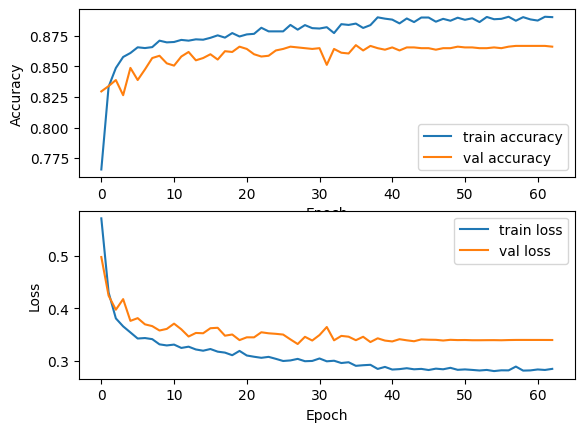

In [60]:
import matplotlib.pyplot as plt
# accuracy and loss in one plot
def plot_history(history, date, model_name):
    fig, axs = plt.subplots(2)
    
    axs[0].plot(history.history['accuracy'], label='train accuracy')
    axs[0].plot(history.history['val_accuracy'], label='val accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    
    axs[1].plot(history.history['loss'], label='train loss')
    axs[1].plot(history.history['val_loss'], label='val loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    
    os.makedirs('images/model_loss', exist_ok=True)
    plt.savefig(f'images/model_loss/{model_name}.png')
    
    plt.show()

plot_history(history, date, model_name)